In [169]:
import json
import os
import random

import pandas as pd
import torch
import torch.nn as nn
from scipy.stats import pearsonr
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# data explore
data_dir = "./Data_n"
dir_list = os.listdir(data_dir)
dir_list.sort(reverse=True)
print(dir_list)

['data_9.json', 'data_8.json', 'data_7.json', 'data_6.json', 'data_5.json', 'data_4.json', 'data_3.json', 'data_2.json', 'data_1.json']


In [62]:
area_names = []
area_codes = []
dates = []
new_Vaccins = []
cum_Vaccins = []
reg_pop = []

for data_path in dir_list[:]:

    dt_js = json.load(open(os.path.join(data_dir, data_path), 'r', encoding='utf-8'))
    for date_data in dt_js['data']:
        #print(date_data['date'])
        area_names.append(date_data['areaName'])
        area_codes.append(date_data['areaCode'])
        dates.append(date_data['date'])

        new = 0
        cum = 0
        reg = 0
        for age_data in date_data['vaccinationsAgeDemographics']:
            if age_data['age'] == '50+' or age_data['age'] == '75+':
                continue
            '''reg += age_data['VaccineRegisterPopulationByVaccinationDate']
            cum += age_data['cumPeopleVaccinatedFirstDoseByVaccinationDate']
            new += age_data['newPeopleVaccinatedFirstDoseByVaccinationDate']'''

            reg += age_data['cumPeopleVaccinatedFirstDoseByVaccinationDate']
            cum += age_data['cumPeopleVaccinatedSecondDoseByVaccinationDate']
            new += age_data['newPeopleVaccinatedSecondDoseByVaccinationDate']
        new_Vaccins.append(new)
        cum_Vaccins.append(cum)
        reg_pop.append(reg)

Data_df = pd.DataFrame({
    'name': area_names,
    'code': area_codes,
    'date': dates,
    'reg': reg_pop,
    'cum': cum_Vaccins,
    'new': new_Vaccins
})
Data_df

,name,code,date,reg,cum,new
0,Yorkshire and The Humber,E12000003,2023-01-11,4256995.0,4052502.0,76.0
1,Yorkshire and The Humber,E12000003,2023-01-10,4256957.0,4052426.0,49.0
2,Yorkshire and The Humber,E12000003,2023-01-09,4256916.0,4052377.0,28.0
3,Yorkshire and The Humber,E12000003,2023-01-08,4256898.0,4052349.0,115.0
4,Yorkshire and The Humber,E12000003,2023-01-07,4256842.0,4052234.0,194.0
...,...,...,...,...,...,...
6880,East Midlands,E12000004,2020-12-12,7293.0,562.0,0.0
6881,East Midlands,E12000004,2020-12-11,6011.0,562.0,14.0
6882,East Midlands,E12000004,2020-12-10,4603.0,548.0,9.0
6883,East Midlands,E12000004,2020-12-09,3033.0,539.0,11.0


In [64]:
data_sp = Data_df
regions_id = list(set(list(data_sp['code'])))
regions_id.sort()
data_region = {}  # 截取每个reigon的data，加入字典里面，每个都由新增和积累两部分
for id in regions_id:
    data_region[id] = data_sp[data_sp["code"] == id]
data_region[regions_id[0]]

,name,code,date,reg,cum,new
3825,North East,E12000001,2023-01-11,2107351.0,2004174.0,20.0
3826,North East,E12000001,2023-01-10,2107339.0,2004154.0,21.0
3827,North East,E12000001,2023-01-09,2107317.0,2004133.0,5.0
3828,North East,E12000001,2023-01-08,2107312.0,2004128.0,16.0
3829,North East,E12000001,2023-01-07,2107301.0,2004112.0,14.0
...,...,...,...,...,...,...
4585,North East,E12000001,2020-12-12,2913.0,486.0,0.0
4586,North East,E12000001,2020-12-11,2748.0,486.0,1.0
4587,North East,E12000001,2020-12-10,2215.0,485.0,7.0
4588,North East,E12000001,2020-12-09,1619.0,478.0,7.0


In [67]:
regions_name = {}
for id in regions_id:
    regions_name[id] = list(data_region[id]['name'])[0]
regions_name

{'E12000001': 'North East',
 'E12000002': 'North West',
 'E12000003': 'Yorkshire and The Humber',
 'E12000004': 'East Midlands',
 'E12000005': 'West Midlands',
 'E12000006': 'East of England',
 'E12000007': 'London',
 'E12000008': 'South East',
 'E12000009': 'South West'}

In [68]:
#对新增和累计求    7日平均
for id in regions_id:
    for i in range(data_region[id].shape[0] - 6):
        #print(data_region[id].iloc[i:i + 7, 2].sum() / 7.0)
        #print(data_region[id].iloc[i:i + 7, 3].sum() / 7.0)
        data_region[id].iloc[i, 4] = data_region[id].iloc[i:i + 7, 4].sum() / 7.0
        data_region[id].iloc[i, 5] = data_region[id].iloc[i:i + 7, 5].sum() / 7.0
    data_region[id] = data_region[id].iloc[:-6]
data_region[regions_id[0]]

,name,code,date,reg,cum,new
3825,North East,E12000001,2023-01-11,2107351.0,2.004120e+06,20.428571
3826,North East,E12000001,2023-01-10,2107339.0,2.004100e+06,22.285714
3827,North East,E12000001,2023-01-09,2107317.0,2.004078e+06,26.000000
3828,North East,E12000001,2023-01-08,2107312.0,2.004052e+06,25.714286
3829,North East,E12000001,2023-01-07,2107301.0,2.004026e+06,23.571429
...,...,...,...,...,...,...
4579,North East,E12000001,2020-12-18,17010.0,4.994286e+02,4.714286
4580,North East,E12000001,2020-12-17,13754.0,4.947143e+02,3.857143
4581,North East,E12000001,2020-12-16,10040.0,4.908571e+02,3.857143
4582,North East,E12000001,2020-12-15,6323.0,4.870000e+02,3.571429


In [69]:
#fig, axes = plt.subplots(5, 2, figsize=(25, 40))
#axes = axes.reshape((-1))
gamma = np.zeros(len(regions_id))
scores = []
epochs = 1
for e in range(epochs):
    print(e)
    for i, id in enumerate(regions_id):
        df = data_region[id]
        df = df.iloc[::-1]
        X = np.array((df['reg'] - df['cum']) * df['reg'] / df['cum']).reshape((-1, 1))
        y = np.array(df['new']).reshape((-1, 1)) + gamma[i] * np.array(df['cum']).reshape((-1, 1))

        LR = LinearRegression(fit_intercept=False)
        LR.fit(X, y)

        sc = LR.score(X, y)
        y_pred = LR.predict(X)

        y_derta = y_pred - y
        X_derta = np.array(df['cum']).reshape((-1, 1))
        LR_derta = LinearRegression(fit_intercept=False)
        LR_derta.fit(X_derta, y_derta)
        gamma[i] = LR_derta.coef_[0][0]
        #print('gamma:', LR_derta.coef_)
        #print('score:', sc)
        X_derta = X_derta.reshape((-1))
        y_derta = y_derta.reshape((-1))
        print(regions_name[id], pearsonr(X_derta, y_derta))
        scores.append(sc)


0
North East PearsonRResult(statistic=0.21872163862120197, pvalue=1.1310630991924513e-09)
North West PearsonRResult(statistic=0.23279655030059868, pvalue=8.449742521259661e-11)
Yorkshire and The Humber PearsonRResult(statistic=0.218904530500316, pvalue=1.0947709657587473e-09)
East Midlands PearsonRResult(statistic=0.2440267500036583, pvalue=9.417446707008895e-12)
West Midlands PearsonRResult(statistic=0.2281493793062293, pvalue=2.028073176902689e-10)
East of England PearsonRResult(statistic=0.22275904901490434, pvalue=5.469135945244661e-10)
London PearsonRResult(statistic=0.20489837025108015, pvalue=1.2252230487578863e-08)
South East PearsonRResult(statistic=0.2118982580904191, pvalue=3.741448079607218e-09)
South West PearsonRResult(statistic=0.22418773282996102, pvalue=4.214937884595067e-10)


In [ ]:
gamma = np.zeros(len(regions_id))
gammas = [1 / 7, 1 / 14, 1 / 21, 1 / 30, 1 / 90, 1 / (30 * 6), 1 / (30 * 9), 1 / (30 * 12), 1 / (30 * 18),
          1 / (30 * 24), 1 / (30 * 30), 1 / (30 * 36), 1 / (30 * 42)]
sc_d = []
gam = gammas[-1]
r0_s = []
sc_sir = []
for gam in gammas:
    sc_sir = []
    for i, id in enumerate(regions_id):
        df = data_region[id]
        df = df.iloc[::-1]

        gamma = np.ones(len(regions_id)) * gam

        X = np.array((df['reg'] - df['cum']) * df['reg'] / df['cum']).reshape((-1, 1))
        y = np.array(df['new']).reshape((-1, 1)) + gamma[i] * np.array(df['cum']).reshape((-1, 1))

        LR = LinearRegression(fit_intercept=False)
        LR.fit(X, y)

        sc = LR.score(X, y)
        sc_sir.append(sc)
        y_pred = LR.predict(X)
        y_pred -= gamma[i] * np.array(df['cum']).reshape((-1, 1))
        #y -= gamma[i] * np.array(df['cum']).reshape((-1, 1))

        #gammas.append(LR.coef_)

        '''plt.plot(range(len(df)), y, label='ture vaccination')
        plt.plot(range(len(df)), y_pred, label='predicted vaccination')
        plt.title(regions_name[id])
        plt.legend()
        plt.show()
        plt.plot(range(len(df)), y, label='ture vaccination')
        plt.plot(range(len(df)), y_pred, label='predicted vaccination')
        plt.title(regions_name[id])
        plt.legend()
        plt.show()'''
        r0_s.append(LR.coef_)
    sc_d.append(np.mean(np.array(sc_sir)))

In [ ]:
t = pd.DataFrame({
    'gamma': gammas,
    'r2_score': sc_d
}).to_latex()

pd.DataFrame({
    'gamma': gammas,
    'r2_score': sc_d
})

In [ ]:
gamma = np.zeros(len(regions_id))
gammas = [1 / 7, 1 / 14, 1 / 21, 1 / 30, 1 / 90, 1 / (30 * 6), 1 / (30 * 9), 1 / (30 * 12), 1 / (30 * 18),
          1 / (30 * 24), 1 / (30 * 30), 1 / (30 * 36), 1 / (30 * 42)]
sc_d = []
gam = gammas[-1]
r0_s = []
sc_sir = []
for i, id in enumerate(regions_id):
    df = data_region[id]
    df = df.iloc[::-1]

    gamma = np.ones(len(regions_id)) * gam

    X = np.array((df['reg'] - df['cum']) * df['reg'] / df['cum']).reshape((-1, 1))
    y = np.array(df['new']).reshape((-1, 1)) + gamma[i] * np.array(df['cum']).reshape((-1, 1))

    LR = LinearRegression(fit_intercept=False)
    LR.fit(X, y)

    sc = LR.score(X, y)
    sc_sir.append(sc)
    y_pred = LR.predict(X)
    y_pred -= gamma[i] * np.array(df['cum']).reshape((-1, 1))
    #y -= gamma[i] * np.array(df['cum']).reshape((-1, 1))

    #gammas.append(LR.coef_)

    '''plt.plot(range(len(df)), y, label='ture vaccination')
    plt.plot(range(len(df)), y_pred, label='predicted vaccination')
    plt.title(regions_name[id])
    plt.legend()
    plt.show()
    plt.plot(range(len(df)), y, label='ture vaccination')
    plt.plot(range(len(df)), y_pred, label='predicted vaccination')
    plt.title(regions_name[id])
    plt.legend()
    plt.show()'''
    r0_s.append(LR.coef_)

In [ ]:
mns = [regions_name[id] for id in regions_id]
r0_s = [x[0][0] for x in r0_s]

t = pd.DataFrame({
    'name': mns,
    'gamma': r0_s
}).to_latex()

pd.DataFrame({
    'name': mns,
    'gamma': r0_s
})

In [ ]:
mns = [regions_name[id] for id in regions_id]
sc_s = [x for x in sc_sir]
t = pd.DataFrame({
    'name': mns,
    'gamma': sc_sir
}).to_latex()

pd.DataFrame({
    'name': mns,
    'gamma': sc_sir
})

In [ ]:
mns = [regions_name[id] for id in regions_id]
gamma_ = [x[0][0] for x in gammas]

t = pd.DataFrame({
    'name': mns,
    'gamma': gamma_
}).to_latex()

pd.DataFrame({
    'name': mns,
    'gamma': gamma_
})

In [ ]:
gamma = np.zeros(len(regions_id))
fig, axes = plt.subplots(5, 2, figsize=(25, 40))
axes = axes.reshape((-1))

error_s = []

for i, id in enumerate(regions_id):
    df = data_region[id]
    df = df.iloc[::-1]
    X = np.array((df['reg'] - df['cum']) * df['reg'] / df['cum']).reshape((-1, 1))
    y = np.array(df['new']).reshape((-1, 1)) + gamma[i] * np.array(df['cum']).reshape((-1, 1))

    LR = LinearRegression(fit_intercept=False)
    LR.fit(X, y)

    sc = LR.score(X, y)
    error_s.append(sc)
    '''y_pred = LR.predict(X)
    y_pred -= gamma[i] * np.array(df['cum']).reshape((-1, 1))
    y -= gamma[i] * np.array(df['cum']).reshape((-1, 1))

    axes[i].plot(range(len(df)), y, label='ture vaccination')
    axes[i].plot(range(len(df)), y_pred, label='predicted vaccination')
    axes[i].set_title(regions_name[id] + " {}".format(sc))
    axes[i].legend()'''

In [70]:
#对新增和累计求    7日平均
for id in regions_id:
    for i in range(data_region[id].shape[0] - 6):
        #print(data_region[id].iloc[i:i + 7, 2].sum() / 7.0)
        #print(data_region[id].iloc[i:i + 7, 3].sum() / 7.0)
        data_region[id].iloc[i, 4] = data_region[id].iloc[i:i + 7, 4].sum() / 7.0
        data_region[id].iloc[i, 5] = data_region[id].iloc[i:i + 7, 5].sum() / 7.0
    data_region[id] = data_region[id].iloc[:-6]
data_region[regions_id[0]]

,name,code,date,reg,cum,new
3825,North East,E12000001,2023-01-11,2107351.0,2.004051e+06,22.734694
3826,North East,E12000001,2023-01-10,2107339.0,2.004028e+06,23.346939
3827,North East,E12000001,2023-01-09,2107317.0,2.004005e+06,23.612245
3828,North East,E12000001,2023-01-08,2107312.0,2.003981e+06,22.428571
3829,North East,E12000001,2023-01-07,2107301.0,2.003959e+06,21.224490
...,...,...,...,...,...,...
4573,North East,E12000001,2020-12-24,43954.0,5.133469e+02,4.408163
4574,North East,E12000001,2020-12-23,42481.0,5.089388e+02,4.530612
4575,North East,E12000001,2020-12-22,35560.0,5.044082e+02,4.551020
4576,North East,E12000001,2020-12-21,30424.0,4.998571e+02,4.367347


In [71]:
years = list(reversed(list(data_region[regions_id[0]]["date"])))
new_df = pd.DataFrame(index=years)
new_new_df = pd.DataFrame(index=years)
cum_df = pd.DataFrame(index=years)
log_df = pd.DataFrame(index=years)
reg_df = pd.DataFrame(index=years)
train_df = pd.DataFrame(index=years)
train_new_df = pd.DataFrame(index=years)
pred_df = pd.DataFrame(index=years)

In [72]:
gamma = np.zeros(len(regions_id))
for i, id in enumerate(regions_id):
    new_df[id] = list(reversed(list(data_region[id]["new"])))
    cum_df[id] = list(reversed(list(data_region[id]["cum"])))

    new_new_df[id] = [new_df[id][x] + gamma[i] * cum_df[id][x] for x in range(len(cum_df))]
    reg_df[id] = list(reversed(list(data_region[id]["reg"])))
    log_df[id] = np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    train_df[id] = new_df[id] / log_df[id]

    train_new_df[id] = new_new_df[id] / log_df[id]

'''for id in regions_id:
    ri = np.array(train_df[id])
    ri_new = np.array(train_new_df[id])
    plt.title(regions_name[id])
    plt.plot(range(len(ri)), ri)
    plt.plot(range(len(ri_new)), ri_new)
    plt.show()'''

print(len(train_df))

753


/var/folders/6r/x8mllzdj4hbc93v2dg25jt_w0000gn/T/ipykernel_80776/1819203974.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_new_df[id] = [new_df[id][x] + gamma[i] * cum_df[id][x] for x in range(len(cum_df))]
/var/folders/6r/x8mllzdj4hbc93v2dg25jt_w0000gn/T/ipykernel_80776/1819203974.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_new_df[id] = [new_df[id][x] + gamma[i] * cum_df[id][x] for x in range(len(cum_df))]
/var/folders/6r/x8mllzdj4hbc93v2dg25jt_w0000gn/T/ipykernel_80776/1819203974.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys 

In [73]:
train_new_df

,E12000001,E12000002,E12000003,E12000004,E12000005,E12000006,E12000007,E12000008,E12000009
2020-12-20,0.008644,0.029393,0.006311,0.016797,0.009909,0.026560,0.004353,0.007275,0.013806
2020-12-21,0.008883,0.027175,0.006656,0.016941,0.009173,0.028986,0.004361,0.007200,0.013602
2020-12-22,0.009152,0.025301,0.006599,0.016503,0.008854,0.029836,0.004566,0.007252,0.013389
2020-12-23,0.009010,0.023036,0.006293,0.015791,0.008349,0.028205,0.004807,0.007376,0.013131
2020-12-24,0.008689,0.019870,0.005614,0.015089,0.007662,0.024480,0.005038,0.007249,0.012031
...,...,...,...,...,...,...,...,...,...
2023-01-07,0.000216,0.000268,0.000235,0.000292,0.000241,0.000291,0.000444,0.000362,0.000308
2023-01-08,0.000228,0.000296,0.000251,0.000300,0.000261,0.000316,0.000472,0.000392,0.000358
2023-01-09,0.000240,0.000329,0.000270,0.000314,0.000286,0.000342,0.000505,0.000430,0.000415
2023-01-10,0.000238,0.000351,0.000288,0.000324,0.000305,0.000363,0.000517,0.000458,0.000458


In [74]:
y = torch.from_numpy(np.array(train_new_df).reshape((-1, 9, 1)) * 100)
x = torch.unsqueeze(torch.linspace(-0.1, 0.9, len(y)), dim=1)

new = torch.from_numpy(np.array(new_df).reshape((-1, 9, 1)))
stat = torch.from_numpy(np.array(log_df).reshape((-1, 9, 1)))

index = [i for i in range(len(y))]
random.shuffle(index)
yi = y[index]
xi = x[index]

In [114]:
#模型定义
class draftSti(nn.Module):

    def __init__(self, n):
        super(draftSti, self).__init__()
        Anp = 5 * np.ones((n, n))
        phinp = np.zeros((n, 1))
        itanp = np.ones((n, 1))
        self.A = nn.Parameter(torch.from_numpy(Anp), requires_grad=True)
        #self.phi = nn.Parameter(torch.from_numpy(phinp), requires_grad=True)
        self.ita = nn.Parameter(torch.from_numpy(itanp), requires_grad=True)

    def forward(self, t):
        out = -1 * torch.abs(self.A) * t
        out = torch.mm(torch.exp(out), self.ita)
        out = torch.add(out, self.ita)

        return out

#模型定义
class draftSingle(nn.Module):

    def __init__(self, n):
        super(draftSingle, self).__init__()
        Anp = np.ones((n))
        itanp = np.zeros((n, 1))
        self.A = nn.Parameter(torch.from_numpy(Anp), requires_grad=True)
        self.ita = nn.Parameter(torch.from_numpy(itanp), requires_grad=True)
        #self.phi = nn.Parameter(torch.from_numpy(itanp), requires_grad=True)

    def forward(self, t):
        out = torch.diag(self.A) * t
        out = torch.mm(torch.exp(out), self.ita)
        out = torch.add(out, self.ita)

        return out

net_bla=net

In [192]:
net = draftSti(9)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_func = torch.nn.MSELoss()


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


# 设置随机数种子
setup_seed(42)
#net.load_state_dict(torch.load("_" + str(40000)))

In [193]:
loss_list = []
leng = 600
all_leng = 759
rec = 0
for k in range(150):

    if k % 10 == 0:
        #torch.save(net.state_dict(), "_" + str(k))
        print(k, rec)

    for i in range(leng):

        #print(net.A.data)
        if i >= leng:
            idx = i % leng
        else:
            idx = i

        xt = xi[idx].to(torch.float64)
        yt = yi[idx].to(torch.float64)

        prediction = net(xt)
        loss = loss_func(prediction, yt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        rec = loss.detach().numpy()

    '''test_loss = 0

    for j in range(leng, all_leng):
        add_loss = loss_func(net(xi[j].to(torch.float64)), yi[j].to(torch.float64)).detach().numpy()
        test_loss += add_loss

    test_loss /= all_leng - leng
    loss_list.append(float(rec))'''

print(net.A.data)
print(net.ita.data)

0 0
10 0.6124635733418816
20 0.539973947239159
30 0.5176864440050879
40 0.500960817588707
50 0.48796317831424474
60 0.47771752419277935
70 0.4695455328923324
80 0.4629600495267703
90 0.4576032814647899
100 0.453207833701736
110 0.4495711037693846
120 0.4465378766527271
130 0.4439881586469232
140 0.44182847558184857
tensor([[5.4871, 5.4886, 5.4843, 5.4910, 5.4910, 5.4966, 5.4827, 5.4909, 5.4889],
        [5.7659, 5.7676, 5.7629, 5.7705, 5.7706, 5.7773, 5.7611, 5.7706, 5.7682],
        [4.9542, 4.9554, 4.9521, 4.9569, 4.9567, 4.9601, 4.9512, 4.9565, 4.9552],
        [5.1648, 5.1658, 5.1628, 5.1672, 5.1674, 5.1709, 5.1617, 5.1673, 5.1658],
        [5.8326, 5.8343, 5.8295, 5.8369, 5.8370, 5.8433, 5.8279, 5.8369, 5.8346],
        [6.8416, 6.8442, 6.8373, 6.8482, 6.8488, 6.8591, 6.8347, 6.8487, 6.8452],
        [4.8492, 4.8504, 4.8469, 4.8522, 4.8520, 4.8558, 4.8458, 4.8517, 4.8504],
        [5.3877, 5.3892, 5.3848, 5.3915, 5.3914, 5.3966, 5.3834, 5.3912, 5.3893],
        [5.1785, 5.1798, 5.

In [200]:
A_best = np.array(net.A.data)

In [231]:
e = 1e-1
cmax = 1e9
Amax=5*np.ones((9,9))
for n in range(2000):
    print("round",n)
    A_best = Amax
    for i in range(100):

        np.random.seed(i * n)
        A_u = np.random.randn(9, 9) * e
        As.append(A_u)

        X = []
        y = []
        new = []
        log_l = []
        for t in range(300):
            A_op = np.exp(-np.abs(A_best + A_u) * (t + 1)) + np.diag(np.ones(9))
            for k in range(9):
                X.append(A_op[k])
                y.append(train_new_df.iloc[t, k])
                new.append(new_new_df.iloc[t, k])
                log_l.append(log_df.iloc[t, k])
        LR = LinearRegression(fit_intercept=False, positive=True, )
        LR.fit(X, y)

        c = mean_squared_error(new, LR.predict(X) * log_l)
        if c < cmax:
            print(c)
            cmax = c
            LR_m = LR
            Amax = A_best + A_u

round 0
69605462.75445704
round 1
69603778.11342235
69603590.84691451
round 2
69601862.65076904
69600864.7688103
round 3
69599074.23271853
69598969.31487396
69598837.9037772
69598371.8336025
69598192.64358078
round 4
69596202.79911661
69596121.05513012
69595810.1290509
69595751.6812868
round 5
69593464.13492832
69591957.38469322
round 6
69589384.28442222
69587069.30398549
round 7
69584150.75452663
69582255.0350303
69580868.84786384
round 8
69577528.2236463
round 9
69573194.08027235
round 10
69567722.75762431
69564214.37038594
round 11
69557920.06388155
round 12
69550079.63689889
round 13
69540363.88600288
round 14
69528321.83826499
69524975.32819688
round 15
69510692.18656403
69505353.16385031
round 16
69488019.04307358
round 17
69465908.16137761
round 18
69437214.67323235
round 19
69399011.20937018
round 20
69346147.322519
69317509.44296455
round 21
69205315.95437188
69193911.92879285
69054490.69212101


KeyboardInterrupt: 

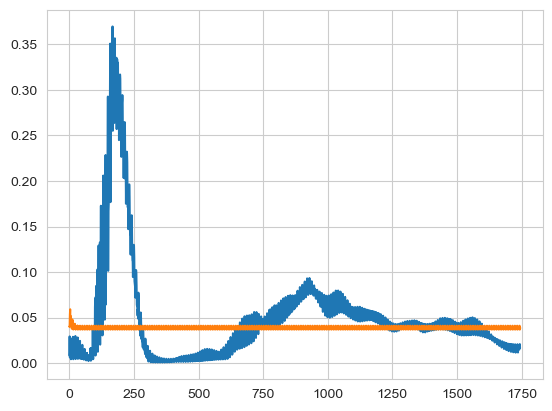

In [232]:
plt.plot(range(len(y)),y)
plt.plot(range(len(LR_m.predict(X))),LR_m.predict(X))

In [218]:
LR.predict(X)

array([0.02213899, 0.02218991, 0.02270537, ..., 0.02116416, 0.02225351,
       0.02205809])

In [196]:
Amax

array([[5.46499747, 5.45523113, 5.3890043 , 5.60130965, 5.55758521,
        5.42799304, 5.53198936, 5.57378388, 5.58640442],
       [5.69980443, 5.6303375 , 5.84858949, 5.72785308, 6.02046124,
        5.75039283, 5.85172868, 5.73031175, 5.83705713],
       [4.83689744, 5.00449867, 5.07573984, 4.92708907, 5.20058585,
        4.98163038, 4.96550616, 5.02740063, 5.23857643],
       [5.13869899, 5.24487036, 4.99362157, 5.13177662, 5.39307114,
        5.24502513, 5.24428044, 5.38791426, 5.22135838],
       [5.87739352, 5.92054888, 5.88059391, 5.74630925, 5.8901277 ,
        5.93041006, 5.74203171, 6.04791379, 5.8127599 ],
       [6.8469909 , 6.76147502, 6.87484132, 6.9994813 , 6.85368355,
        6.89377684, 6.71623951, 6.89837375, 6.81661133],
       [5.02660052, 5.03761603, 4.86474889, 4.90800986, 4.98499529,
        5.0243182 , 4.9663348 , 4.88624873, 5.07984525],
       [5.5246259 , 5.16832747, 5.37361699, 5.32656945, 5.39381985,
        5.30174115, 5.44293736, 5.45942916, 5.36740681],


In [197]:
LR.coef_

array([0.03187954, 0.03233319, 0.03112649, 0.03421088, 0.03393847,
       0.03606949, 0.02942306, 0.03218205, 0.03216761])

In [159]:
A_best = Amax

s = 0
e = 1
cmax = -100
Amax = 0
LR_m = 0
for i in tqdm(range(100)):

    np.random.seed(s)
    s += 1
    A_u = np.random.randn(9, 9) * e

    X = []
    y = []
    for t in range(700):
        A_op = np.exp(-np.abs(A_best + A_u) * t) + np.diag(np.ones(9))
        for k in range(9):
            X.append(A_op[k])
            y.append(train_new_df.iloc[t, k])
    LR = LinearRegression(fit_intercept=False, positive=True)
    LR.fit(X, y)
    c = LR.score(X, y)
    if c > cmax:
        cmax = c
        LR_m = LR
        Amax = A_best + A_u

100%|██████████| 100/100 [00:31<00:00,  3.20it/s]


In [ ]:
for n in range(30):


In [160]:
cmax

-0.030070279291132263

In [161]:
Amax

array([[7.20000344, 7.06559675, 5.89691684, 4.4697568 , 7.41056508,
        4.18073412, 6.27660226, 5.44562426, 5.62218968],
       [4.23792425, 8.30267179, 3.6755927 , 4.55626105, 3.84718902,
        5.97810477, 4.87084318, 4.86553926, 5.97316011],
       [4.70775807, 5.61402144, 3.58841387, 4.87939178, 6.12696497,
        6.00856537, 5.37189149, 2.83663721, 5.70945326],
       [6.569711  , 3.35672245, 5.45873203, 4.64692698, 5.4754092 ,
        3.5973659 , 4.39749908, 5.03390853, 6.09782613],
       [6.22557217, 5.44520174, 6.71284543, 5.79996212, 5.32866239,
        4.77738044, 4.25602726, 8.85549974, 4.46180047],
       [4.70566925, 7.01146101, 9.3326636 , 7.60880252, 6.82644185,
        6.04492371, 7.08428688, 4.72213422, 6.95524197],
       [5.04345065, 4.67928519, 6.12980169, 5.87117917, 4.81659269,
        6.51539608, 4.06603062, 6.83857016, 5.41598673],
       [5.76171438, 5.56740027, 4.53163333, 7.96470063, 5.69724858,
        6.55736772, 4.3925733 , 4.21896377, 4.38940741],


In [164]:
pearsonr(Amax.mean(axis=0), Amax.mean(axis=1))

PearsonRResult(statistic=-0.05367871451943743, pvalue=0.8909088564829897)

In [157]:
np.array(LR.coef_)

array([0.01623507, 0.0164713 , 0.01627153, 0.01734604, 0.01696038,
       0.01803767, 0.01611629, 0.0171565 , 0.01696621])

In [154]:
Amax

array([[7.09311914, 4.8597815 , 4.94035415, 4.4013457 , 6.34205127,
        3.18355148, 7.20815017, 4.71519377, 5.79340337],
       [5.52661543, 7.24123586, 3.71609398, 5.45998246, 5.40132205,
        6.92923761, 4.6703173 , 5.61286823, 4.90507926],
       [4.98478186, 5.52746404, 3.84163468, 6.09143279, 5.84969216,
        5.45634629, 5.8396342 , 4.26412988, 4.82364875],
       [4.20907724, 4.87872872, 5.67467706, 4.45660024, 4.7531531 ,
        4.468082  , 4.29574975, 4.47855005, 5.13556476],
       [4.79207276, 6.14701952, 7.56979745, 6.6581202 , 5.72717912,
        5.04179272, 5.15675281, 7.61145933, 5.96752398],
       [6.49544151, 7.32821324, 9.23376126, 7.26265716, 7.76469862,
        7.46444641, 6.77205812, 6.00498337, 6.79453747],
       [4.58892536, 5.38667634, 5.63599116, 5.73323272, 5.08917952,
        5.69473625, 4.03886651, 6.05602126, 5.31463501],
       [5.1143834 , 5.90389923, 5.33683357, 6.54999619, 6.94048477,
        7.6149619 , 4.01065785, 3.97630158, 4.91399623],


In [93]:
np.array(net.ita.data)

array([[0.38700377],
       [0.45220753],
       [0.453202  ],
       [0.4680375 ],
       [0.57583175],
       [0.76658502],
       [0.31763727],
       [0.55521026],
       [0.54126429]])

In [0]:
pd.DataFrame(np.array(net.A.detach().numpy()),
             index=[regions_name[id] for id in regions_id],
             columns=[regions_name[id] for id in regions_id])

In [ ]:
pd.DataFrame(np.array(net.ita.detach().numpy()),
             index=[regions_name[id] for id in regions_id])

In [ ]:
t = pd.DataFrame(-np.absolute(net.A.detach().numpy()).round(3),
                 index=[regions_name[id] for id in regions_id],
                 columns=[regions_name[id] for id in regions_id]).to_latex()
print(t)

In [ ]:
t = pd.DataFrame(np.absolute(net.ita.detach().numpy()),
                 index=[regions_name[id] for id in regions_id]).to_latex()
print(t)

In [121]:
len(train_df)

y_pred = []
for i in x:
    y_pred.append(net(i).detach().numpy())
y_pred = np.array(y_pred)
#y_pred

import pickle

pickle.dump(y_pred, open('./y_pred_2nd.pkl', 'wb'))

In [ ]:
import pickle

y_pred = pickle.load(open('./y_pred_2nd.pkl', 'rb'))

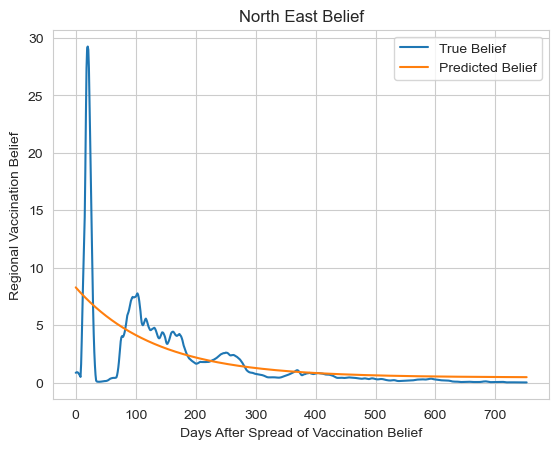

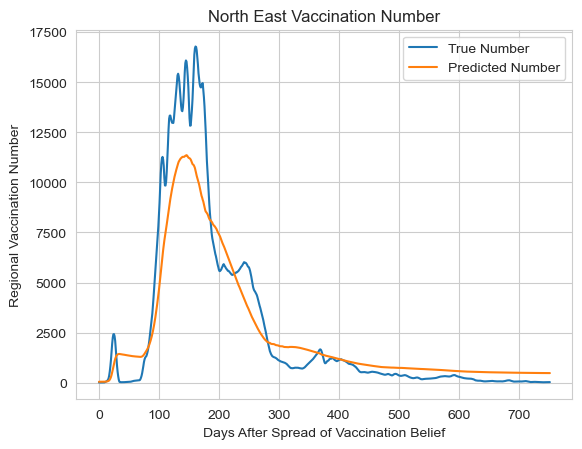

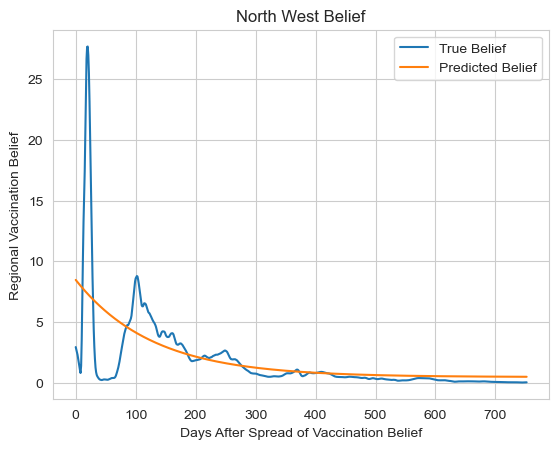

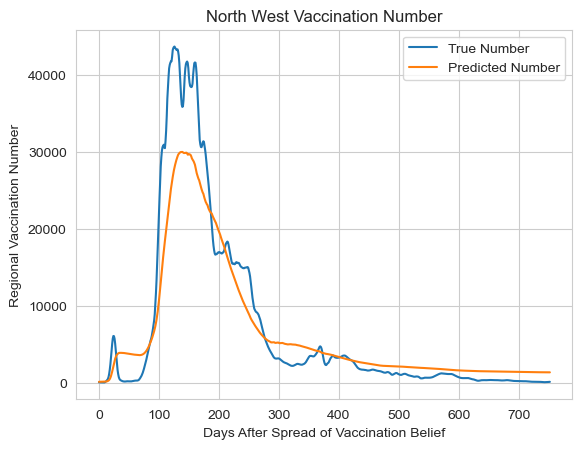

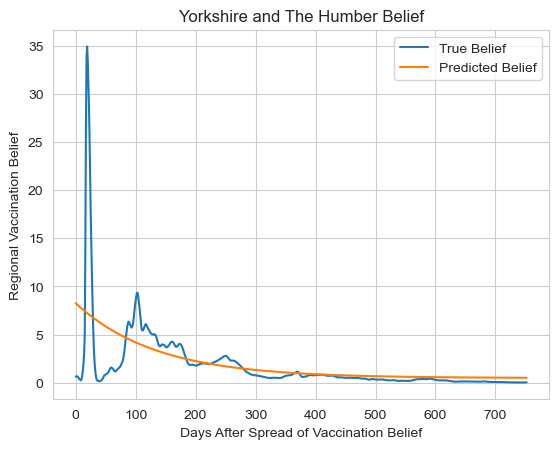

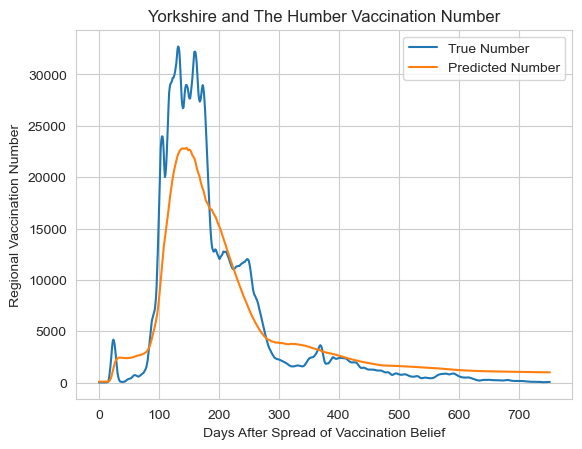

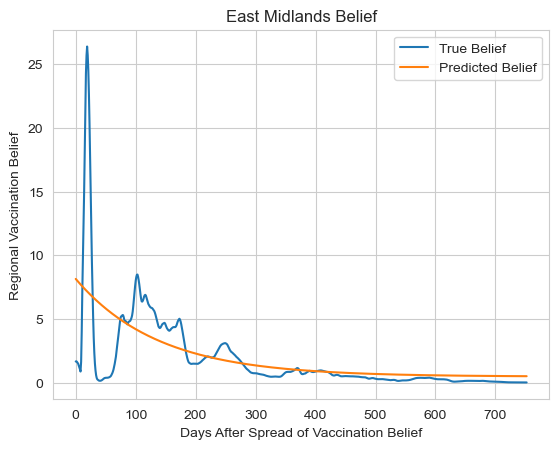

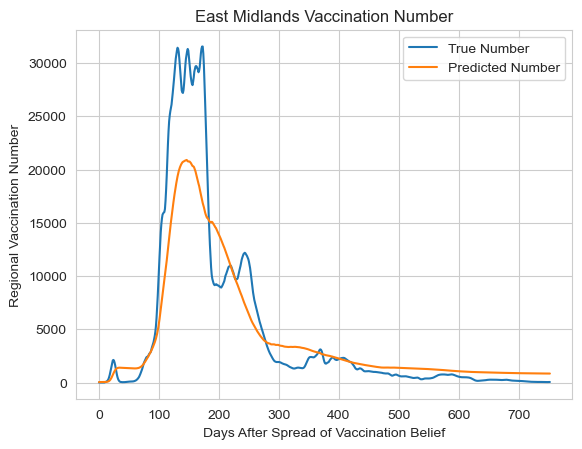

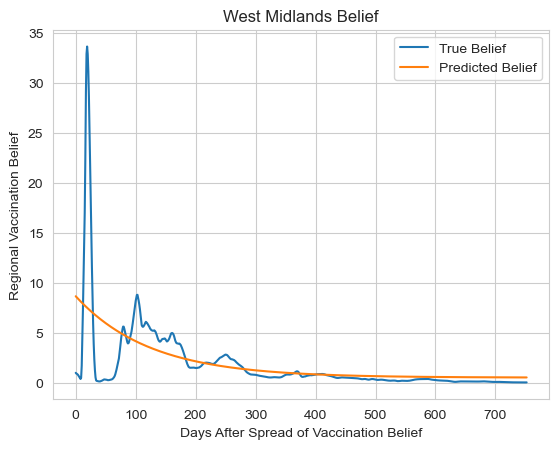

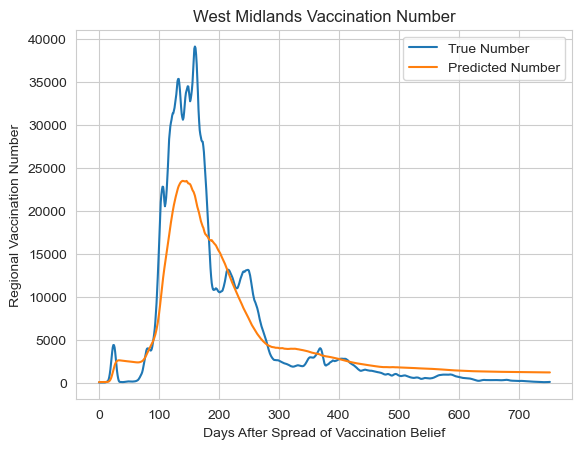

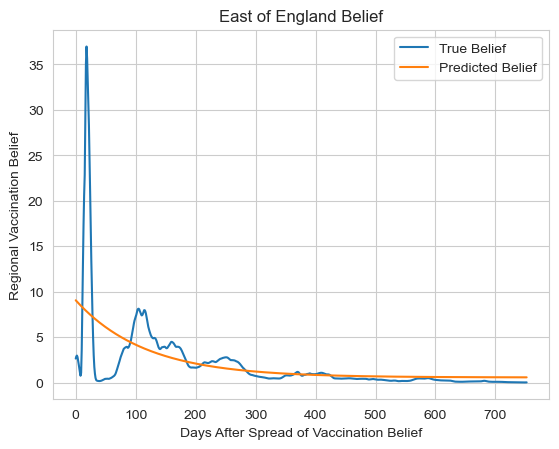

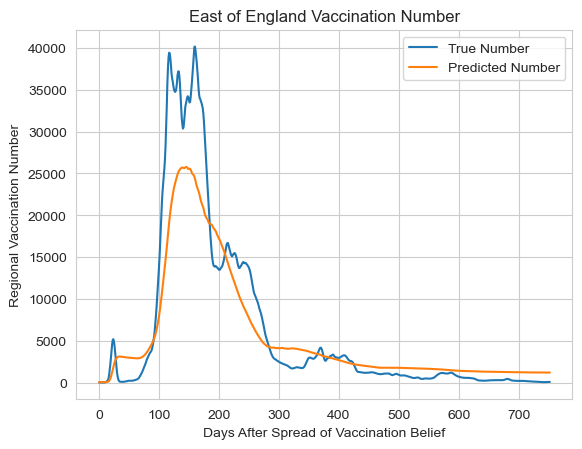

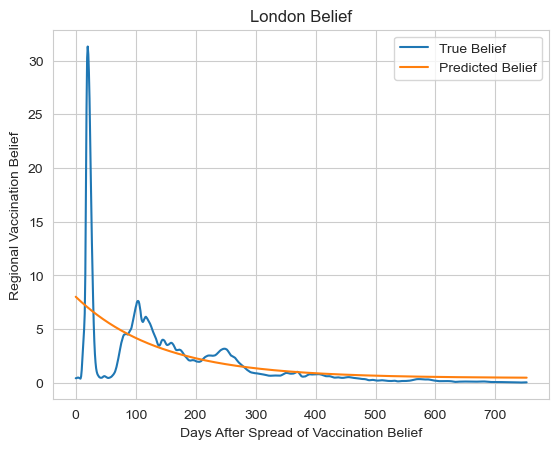

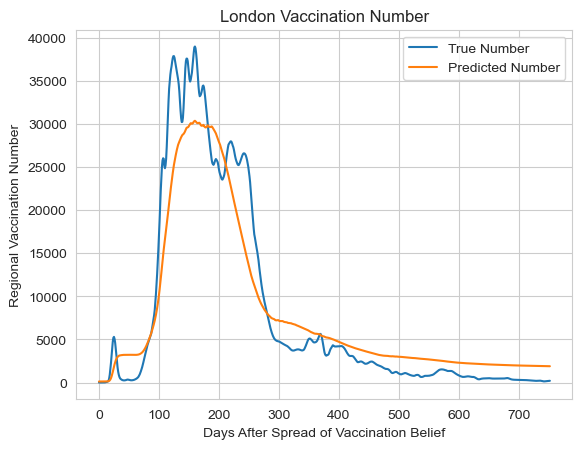

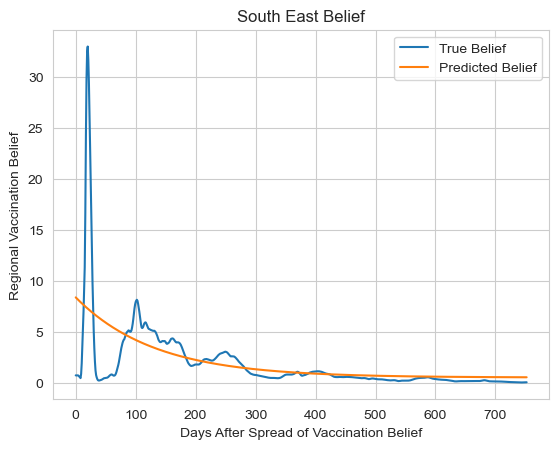

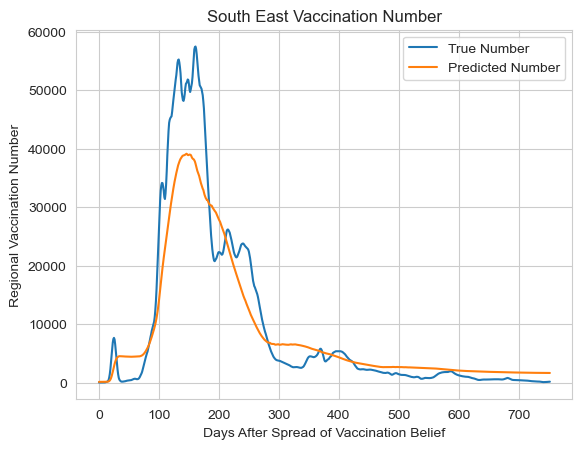

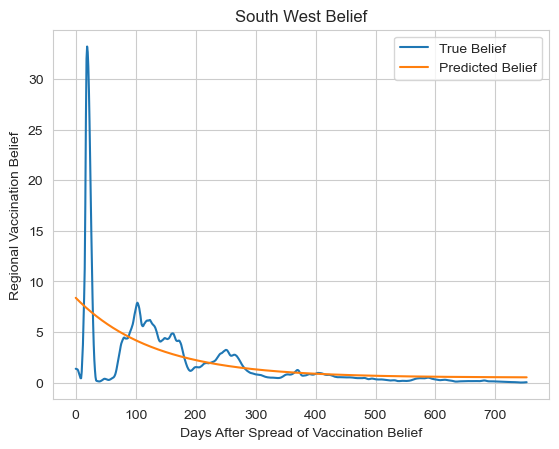

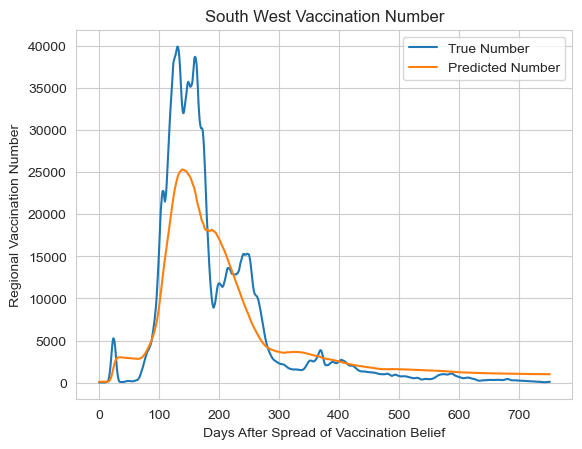

In [126]:
sc_s = []
for i in range(9):
    y_t = np.array(y[:, i]).reshape((-1))
    y_p = np.array(y_pred[:, i]).reshape((-1))

    id = regions_id[i]
    plt.title(regions_name[id] + " Belief")
    plt.xlabel("Days After Spread of Vaccination Belief")
    plt.ylabel("Regional Vaccination Belief")
    plt.plot(range(len(x)), y_t, label="True Belief")
    plt.plot(range(len(x)), y_p, label="Predicted Belief")
    plt.legend()
    plt.show()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    plt.title(regions_name[id] + " Vaccination Number")
    plt.xlabel("Days After Spread of Vaccination Belief")
    plt.ylabel("Regional Vaccination Number")
    plt.plot(range(len(x)), true_end, label="True Number")
    plt.plot(range(len(x)), pred_end, label="Predicted Number")
    sc_s.append(r2_score(true_end, pred_end))
    plt.legend()
    plt.show()

In [ ]:
mns = [regions_name[id] for id in regions_id]
sc_s = [x for x in sc_s]
t = pd.DataFrame({
    'Name': mns,
    'SIR Model': sc_sir,
    'Network Model': sc_s
}).to_latex()
print(t)

fig, axes = plt.subplots(3, 2, figsize=(15, 18))
for i in range(3)[:]:
    y_t = np.array(y[:, i]).reshape((-1))
    y_p = np.array(y_pred[:, i]).reshape((-1))

    id = regions_id[i]
    axes[i, 0].set_title(regions_name[id] + " Belief")
    axes[i, 0].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 0].set_ylabel("Regional Vaccination Belief")
    axes[i, 0].plot(range(len(x)), y_t, label="True Belief")
    axes[i, 0].plot(range(len(x)), y_p, label="Predicted Belief")
    axes[i, 0].legend()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    axes[i, 1].set_title(regions_name[id] + " Vaccination Number")
    axes[i, 1].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 1].set_ylabel("Regional Vaccination Number")
    axes[i, 1].plot(range(len(x)), true_end, label="True Number")
    axes[i, 1].plot(range(len(x)), pred_end, label="Predicted Number")
    axes[i, 1].legend()
plt.show()

fig, axes = plt.subplots(4, 2, figsize=(15, 24))
for i in range(4)[:]:
    y_t = np.array(y[:, i + 3]).reshape((-1))
    y_p = np.array(y_pred[:, i + 3]).reshape((-1))

    id = regions_id[i + 3]
    axes[i, 0].set_title(regions_name[id] + " Belief")
    axes[i, 0].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 0].set_ylabel("Regional Vaccination Belief")
    axes[i, 0].plot(range(len(x)), y_t, label="True Belief")
    axes[i, 0].plot(range(len(x)), y_p, label="Predicted Belief")
    axes[i, 0].legend()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    axes[i, 1].set_title(regions_name[id] + " Vaccination Number")
    axes[i, 1].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 1].set_ylabel("Regional Vaccination Number")
    axes[i, 1].plot(range(len(x)), true_end, label="True Number")
    axes[i, 1].plot(range(len(x)), pred_end, label="Predicted Number")
    axes[i, 1].legend()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i in range(2)[:]:
    y_t = np.array(y[:, i + 7]).reshape((-1))
    y_p = np.array(y_pred[:, i + 7]).reshape((-1))

    id = regions_id[i + 7]
    axes[i, 0].set_title(regions_name[id] + " Belief")
    axes[i, 0].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 0].set_ylabel("Regional Vaccination Belief")
    axes[i, 0].plot(range(len(x)), y_t, label="True Belief")
    axes[i, 0].plot(range(len(x)), y_p, label="Predicted Belief")
    axes[i, 0].legend()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    axes[i, 1].set_title(regions_name[id] + " Vaccination Number")
    axes[i, 1].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 1].set_ylabel("Regional Vaccination Number")
    axes[i, 1].plot(range(len(x)), true_end, label="True Number")
    axes[i, 1].plot(range(len(x)), pred_end, label="Predicted Number")
    axes[i, 1].legend()
plt.show()

fig, axes = plt.subplots(4, 2, figsize=(25, 40))
for i in range(4)[:]:
    y_t = np.array(y[:, i + 5]).reshape((-1))
    y_p = np.array(y_pred[:, i + 5]).reshape((-1))

    id = regions_id[i + 5]
    axes[i, 0].set_title(regions_name[id] + " Belief")
    axes[i, 0].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 0].set_ylabel("Regional Vaccination Belief")
    axes[i, 0].plot(range(len(x)), y_t, label="True Belief")
    axes[i, 0].plot(range(len(x)), y_p, label="Predicted Belief")
    axes[i, 0].legend()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    axes[i, 1].set_title(regions_name[id] + " Vaccination Number")
    axes[i, 1].set_xlabel("Days After Spread of Vaccination Belief")
    axes[i, 1].set_ylabel("Regional Vaccination Number")
    axes[i, 1].plot(range(len(x)), true_end, label="True Number")
    axes[i, 1].plot(range(len(x)), pred_end, label="Predicted Number")
    axes[i, 1].legend()
plt.show()

In [ ]:
net_comp = draftSingle(9)
optimizer = torch.optim.SGD(net_comp.parameters(), lr=1e-2)
loss_func = torch.nn.MSELoss()

In [ ]:
loss_list = []
leng = 200
all_leng = 759
rec = 0
for k in range(2001):

    if k % 100 == 0:
        #torch.save(net.state_dict(), "_" + str(k))
        print(k, rec)

    for i in range(leng):

        #print(net.A.data)
        if i >= leng:
            idx = i % leng
        else:
            idx = i

        xt = xi[idx].to(torch.float64)
        yt = yi[idx].to(torch.float64)

        prediction = net_comp(xt)
        loss = loss_func(prediction, yt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        rec = loss.detach().numpy()

    '''test_loss = 0

    for j in range(leng, all_leng):
        add_loss = loss_func(net(xi[j].to(torch.float64)), yi[j].to(torch.float64)).detach().numpy()
        test_loss += add_loss

    test_loss /= all_leng - leng
    loss_list.append(float(rec))'''

print(net_comp.A.data)
print(net_comp.ita.data)

In [ ]:
len(train_df)

y_pred = []
for i in x:
    y_pred.append(net_comp(i).detach().numpy())
y_pred = np.array(y_pred)

In [ ]:
for i in range(9):
    y_t = np.array(y[:, i]).reshape((-1))
    y_p = np.array(y_pred[:, i]).reshape((-1))

    id = regions_id[i]
    plt.title(regions_name[id] + " Belief")
    plt.xlabel("Days After Spread of Vaccination Belief")
    plt.ylabel("Regional Vaccination Belief")
    plt.plot(range(len(x)), y_t, label="True Belief")
    plt.plot(range(len(x)), y_p, label="Predicted Belief")
    plt.legend()
    plt.show()

    true_end = np.array(y_t) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    pred_end = np.array(y_p) / 100 * np.array(cum_df[id]) * (1 - np.array(cum_df[id]) / np.array(reg_df[id]))
    plt.title(regions_name[id] + " Vaccination Number")
    plt.xlabel("Days After Spread of Vaccination Belief")
    plt.ylabel("Regional Vaccination Number")
    plt.plot(range(len(x)), true_end, label="True Number")
    plt.plot(range(len(x)), pred_end, label="Predicted Number")
    plt.legend()
    plt.show()

In [ ]:
rg_names = []
for i in regions_id:
    rg_names.append(regions_name[i])

In [ ]:
pd.DataFrame([[-10.7596, -10.7596, -10.7596, -10.7596, -10.7596, -10.7596, -10.7596,
               -10.7596, -10.7596],
              [-10.2862, -10.2862, -10.2862, -10.2862, -10.2862, -10.2862, -10.2862,
               -10.2862, -10.2862],
              [-11.0944, -11.0944, -11.0944, -11.0944, -11.0944, -11.0944, -11.0944,
               -11.0944, -11.0944],
              [-9.6007, -9.6007, -9.6007, -9.6007, -9.6007, -9.6007, -9.6007,
               -9.6007, -9.6007],
              [-11.2211, -11.2211, -11.2211, -11.2211, -11.2211, -11.2211, -11.2211,
               -11.2211, -11.2211],
              [-10.3126, -10.3126, -10.3126, -10.3126, -10.3126, -10.3126, -10.3126,
               -10.3126, -10.3126],
              [-10.2468, -10.2468, -10.2468, -10.2468, -10.2468, -10.2468, -10.2468,
               -10.2468, -10.2468],
              [-10.5677, -10.5677, -10.5677, -10.5677, -10.5677, -10.5677, -10.5677,
               -10.5677, -10.5677],
              [-10.6959, -10.6959, -10.6959, -10.6959, -10.6959, -10.6959, -10.6959,
               -10.6959, -10.6959]], columns=rg_names, index=rg_names)

In [ ]:
pd.DataFrame({
    "names": rg_names,
    "": [-0.2272,
         -0.2568,
         -0.2047,
         -0.2501,
         -0.2339,
         -0.2112,
         -0.2414,
         -0.2187,
         -0.2120]})

In [ ]:
import networkx as nx

In [ ]:
G = nx.complete_graph(9)


In [ ]:
nm = {}
lm = {}
for i, n in enumerate(['North East',
                       'North West',
                       'South West',
                       'E.Midlands',
                       'W. Midlands',
                       'London',
                       'E. England',
                       'South East',
                       'Yorkshire']):
    nm[i] = {'name': n}
    lm[i] = n
#nx.set_node_attributes(G, nm)

In [ ]:
A = pd.read_csv('./matrix_with_7021.csv')
np.array(A)

In [ ]:

G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)
layout = nx.spring_layout(G)
print(layout)

In [ ]:
plt.figure(figsize=(25, 20))
nx.draw_networkx_edges(G, layout, width=[float(d['weight'] * 0.03) for (u, v, d) in G.edges(data=True)], arrows=True,
                       connectionstyle="arc3,rad=0.3")
nx.draw_networkx_nodes(G, layout, node_size=100)
nx.draw_networkx_labels(G, layout, labels=lm, font_size=20, verticalalignment='top', horizontalalignment='left')
#nx.draw_networkx(G, labels=lm, with_labels=True)
plt.savefig('./nt.png')
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
layout = nx.spring_layout(G)
nx.draw_networkx(G, layout)
nx.draw_networkx_edge_labels(G, pos=layout)
plt.show()

In [ ]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, labels=lm, with_labels=True)

In [ ]:
import pandas as pd

df = pd.read_csv("./matrix_with_9974.csv")
df.columns = ['North East',
              'North West',
              'South West',
              'East Midlands',
              'West Midlands',
              'London',
              'East of England',
              'South East',
              'Yorkshire & Humber']
df.index = ['North East',
            'North West',
            'South West',
            'East Midlands',
            'West Midlands',
            'London',
            'East of England',
            'South East',
            'Yorkshire & Humber']

In [ ]:
df = df.round(3)
df.to_csv('./table.csv')